In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import entr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, KDTree
from math import log

scipy.special.entr
elementwise function for computing entropy
$$ f(x)=\left\{
\begin{aligned}
& -xlog(x) x>0 \\
& 0 \quad x=0 \\
& \infty \quad otherwise
\end{aligned}
\right.
$$

In [2]:
%run ./function.ipynb

In [3]:
#PATH = 'C:/Users/NCTUUser2/Desktop/mark/'
PATH  = 'C:/Users/mark0/Desktop/捷智/MetaEdge/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [4]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [5]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


C:\Users\mark0\AppData\Local\Temp\ipykernel_12724\2736333543.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train_Non_SAR.append(train_TO_SAR)
C:\Users\mark0\AppData\Local\Temp\ipykernel_12724\2736333543.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test_Non_SAR.append(test_TO_SAR)


In [6]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
print(f'train_set:{train_set.shape}\n' + f'test_set:{test_set.shape}')

train_set:(52060, 38)
test_set:(34709, 38)


In [7]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

In [8]:
np.max(SAR['Credit_Amt'])

6840000.0

In [9]:
np.max(Non_SAR['Credit_Amt'])

23214500.0

In [10]:
np.max(SAR['number_of_Credit'])

98.0

In [11]:
np.max(Non_SAR['number_of_Credit'])

852.0

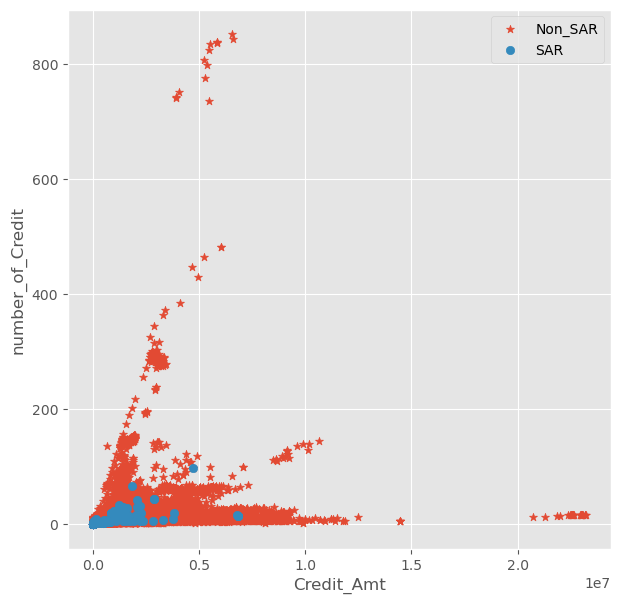

In [10]:
plt.figure(figsize= (7, 7))
plt.style.use('ggplot')
plt.scatter(Non_SAR['Credit_Amt'], Non_SAR['number_of_Credit'], marker= '*', label= 'Non_SAR')
plt.scatter(SAR['Credit_Amt'], SAR['number_of_Credit'], marker= 'o', label= 'SAR')
plt.xlabel('Credit_Amt')
plt.ylabel('number_of_Credit')
plt.legend()
plt.show()

In [11]:
credit_amt_threshold = np.unique(SAR['Credit_Amt']).tolist()
number_of_credit_threshold = np.unique(SAR['number_of_Credit']).tolist()
print(len(credit_amt_threshold), len(number_of_credit_threshold))

86 33


In [14]:
# Hyper parameter settings
RANK = 10
SLICE = 86
beta = 2 # give recall weight=2

In [15]:
LOGIC = "OR"
default_number_of_credit  = 0
default_credit_amt = 0
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.3987044048677559 number of max val:  2
Rank: 10, countMax: 2, 100- countZero: 2803
1th, recall: 0.40823970037453183, val1: 0.0, val2: 4000.0
87th, recall: 0.40823970037453183, val1: 1.0, val2: 4000.0
86th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
2th, recall: 0.40074906367041196, val1: 0.0, val2: 11405.0
88th, recall: 0.40074906367041196, val1: 1.0, val2: 11405.0
3th, recall: 0.3970037453183521, val1: 0.0, val2: 16000.0
89th, recall: 0.3970037453183521, val1: 1.0, val2: 16000.0
4th, recall: 0.3895131086142322, val1: 0.0, val2: 20000.0
90th, recall: 0.3895131086142322, val1: 1.0, val2: 20000.0
175th, recall: 0.37453183520599254, val1: 2.0, val2: 16000.0
********************************


In [77]:
thre1 = SAR['Credit_Amt'].min()
thre2 = SAR['number_of_Credit'].min()

idx1 = set(train_set[train_set['Credit_Amt'] >= thre1].index)
idx2 = set(train_set[train_set['number_of_Credit'] >= thre2].index)

idx = list(idx1 & idx2)
new_SAM_1 = train_set.iloc[idx]
new_SAM_0 = train_set.drop(index= new_SAM_1.index)

TP = new_SAM_1[new_SAM_1[SAR_type] != 0].shape[0]
TN = new_SAM_0[new_SAM_0[SAR_type] == 0].shape[0]
FP = new_SAM_1[new_SAM_1[SAR_type] == 0].shape[0]
FN = new_SAM_0[new_SAM_0[SAR_type] != 0].shape[0]

recallRate = TP / (TP + FN)
filterRate = (TN + FN) / (TP + FP + TN + FN)


recall 的定義是 $\frac{TP}{TP+FN}$，應該是找 SAR 中最小的 Credit_Amt 和 number_of_Credit 才對

In [78]:
print(TP, TN, FP, FN)

267 0 51793 0


In [79]:
print('recall:', recallRate, 'filter rate', filterRate)

recall: 1.0 filter rate 0.0


In [64]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []

FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 40):
        threshold_list[i].append(np.percentile(tmp, j))
        
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16000.0, 61968.0, 292378.4615384626, 483194.153846153, 668833.6, 806769.23076923, 949076.9230769229, 993144.6153846153, 1051884.6153846155, 1101953.8461538462, 1226061.5384615385, 1300169.2307692308, 1426076.9230769225, 1632338.4615384587, 2057999.9999999993, 2273125.9692307673, 3732153.8461538306, 6840000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 3.0, 5.0, 5.338461538461502, 6.0, 7.0, 8.753846153846155, 11.0, 13.0, 14.16923076923075, 16.0, 18.0, 21.0, 24.72307692307689, 30.72307692307686, 98.0]

[0.0, 1000.0, 15433.846153846156, 62277.000000000065, 100000.0, 314621.2307692305, 725998.076923077, 849976.3076923077, 900000.0, 966376.1538461538, 989913.5076923076, 1000000.0, 1020298.1538461539, 1050000.0, 1050000.0, 1076809.8461538462, 1102014.0, 1126464.0769230768, 1170558.3846153845, 1190105

In [65]:
# Hyper parameter settings
RANK = 10
SLICE = 40
beta = 2 # give recall weight=2

In [66]:
LOGIC = "OR"
default_number_of_credit  = 5
default_credit_amt = 985500
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.26262948256054164 number of max val:  1
Rank: 10, countMax: 1, 100- countZero: 147
1069th, recall: 0.23220973782771537, val1: 5.0, val2: 993144.6153846153
1109th, recall: 0.21722846441947566, val1: 5.338461538461502, val2: 993144.6153846153
1149th, recall: 0.21722846441947566, val1: 6.0, val2: 993144.6153846153
1070th, recall: 0.20973782771535582, val1: 5.0, val2: 1051884.6153846155
1189th, recall: 0.20224719101123595, val1: 7.0, val2: 993144.6153846153
1110th, recall: 0.1947565543071161, val1: 5.338461538461502, val2: 1051884.6153846155
1150th, recall: 0.1947565543071161, val1: 6.0, val2: 1051884.6153846155
1071th, recall: 0.18726591760299627, val1: 5.0, val2: 1101953.8461538462
1229th, recall: 0.18352059925093633, val1: 8.753846153846155, val2: 993144.6153846153
1190th, recall: 0.1797752808988764, val1: 7.0, val2: 1051884.6153846155
********************************


In [63]:
LOGIC = "OR"
default_number_of_credit  = 0
default_credit_amt = 0
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, SAR, \
                            Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.39730453715148556 number of max val:  24
Rank: 10, countMax: 24, 100- countZero: 1377
480th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
481th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
482th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
483th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
484th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
485th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
486th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
487th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
488th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
489th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
490th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
491th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
520th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
521th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
522th, recall: 0.40823970037453183, val1: 1.0, val2: 0.0
523th, recall: 0.40823970037453183, val1: 1.0, 

### check 微分分子為零的情況

In [12]:
sort_Credit_Amt = np.unique(SAR['Credit_Amt'])
sort_number_of_Credit = np.unique(SAR['number_of_Credit'])

In [19]:
sort_Credit_Amt[-1]

6840000.0

In [9]:
def conditionalEntropy(new_sam_0 , new_sam_1):
    total = len(new_sam_1) + len(new_sam_0)
    return Entropy(new_sam_0) * (len(new_sam_0) / total) \
            + Entropy(new_sam_1, SAR_type) * (len(new_sam_1) / total)

In [10]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    #print(len(new_sam_1), len(new_sam_0))
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [11]:
point = train_set[['Credit_Amt', 'number_of_Credit']]
credit_kdtree = cKDTree(point, leafsize= 100)

In [12]:
def gradientIG(point, x_name, y_name, data):
    _, auxiliary_idx = credit_kdtree.query(point)
    auxiliary = train_set[auxiliary_idx]
    delta = auxiliary - point
    z = informationGain(point, x_name, y_name, data)
    z_delta = [informationGain(np.array([[auxiliary[[0]]], point[[1]]]), x_name, y_name, data), \
        informationGain(np.array([[point[[0]]], auxiliary[[1]]]), x_name, y_name, data)]
    grad = (z_delta - z) / delta

## SAR 點到原點的距離

In [13]:
SAR.shape

(267, 40)

In [12]:
tmp = (SAR.loc[:, 'Credit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Credit'].to_numpy())**(1/2)
SAR.insert(0,'SAR_Credit_distance', tmp)
tmp= (SAR.loc[:, 'Debit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Debit'].to_numpy())**(1/2)
SAR.insert(0, 'SAR_Debit_distance', tmp)

del tmp 

In [14]:
SAR.loc[:, ['SAR_Credit_distance', 'SAR_Debit_distance']]

,SAR_Credit_distance,SAR_Debit_distance
115,0.000000e+00,5.499450e+05
182,0.000000e+00,2.462000e+03
437,0.000000e+00,6.999450e+05
819,0.000000e+00,8.499450e+05
820,8.400000e+05,0.000000e+00
...,...,...
52055,1.865654e+06,0.000000e+00
52056,2.085000e+06,0.000000e+00
52057,4.000000e+03,2.068505e+06
52058,4.000000e+03,2.368505e+06


In [15]:
idx_SAR_Credit_distance = SAR.loc[SAR['SAR_Credit_distance']!=0].sort_values(by= 'SAR_Credit_distance').index
idx_SAR_Debit_distance = SAR.loc[SAR['SAR_Debit_distance']!=0].sort_values(by= 'SAR_Debit_distance').index
print(len(idx_SAR_Credit_distance), len(idx_SAR_Debit_distance))

109 235


In [16]:
SAR.loc[SAR['SAR_Credit_distance']!=0].sort_values(by= 'SAR_Credit_distance')[['Credit_Amt', 'number_of_Credit', 'SAR_Credit_distance']]

,Credit_Amt,number_of_Credit,SAR_Credit_distance
52058,4000.0,1.0,4.000000e+03
52057,4000.0,1.0,4.000000e+03
31054,11405.0,1.0,1.140500e+04
21068,16000.0,2.0,1.600000e+04
20450,16000.0,2.0,1.600000e+04
...,...,...,...
49214,4737000.0,98.0,4.737000e+06
20447,6785000.0,16.0,6.785000e+06
7073,6840000.0,14.0,6.840000e+06
6881,6840000.0,14.0,6.840000e+06


In [17]:
SAR.loc[SAR['SAR_Debit_distance']!=0].sort_values(by= 'SAR_Debit_distance')[['Debit_Amt', 'number_of_Debit', 'SAR_Debit_distance']]

,Debit_Amt,number_of_Debit,SAR_Debit_distance
49214,1000.0,1.0,1.000000e+03
26355,1000.0,2.0,1.000001e+03
26186,1000.0,2.0,1.000001e+03
26532,2000.0,3.0,2.000001e+03
182,2462.0,2.0,2.462000e+03
...,...,...,...
27450,5839000.0,34.0,5.839000e+06
8924,7590025.0,8.0,7.590025e+06
34723,10160040.0,9.0,1.016004e+07
9169,10550015.0,7.0,1.055002e+07


In [18]:
def RecallFilterRate(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

In [20]:
debit_distance_results = pd.DataFrame(columns= ['Debit_Amt', 'number_of_Debit', 'recall', 'filterRate', 'distance'])

for _, idx in enumerate(idx_SAR_Debit_distance):
    x, y = SAR.loc[idx][['Debit_Amt', 'number_of_Debit']]
    distance = (x**2 + y**2)**(1/2)
    recall_tmp, filterRate_tmp= RecallFilterRate(np.array([[x], [y]]), 'Debit_Amt', 'number_of_Debit', train_set)
    tmp = pd.DataFrame({'Debit_Amt':[x], 'number_of_Debit':[y], 'recall': [recall_tmp], 'filterRate': [filterRate_tmp], 'distance': distance})
    debit_distance_results = pd.concat([debit_distance_results, tmp])

In [25]:
debit_distance_results.sort_values(by= ['distance', 'recall'], ascending= True)[:10]

,Debit_Amt,number_of_Debit,recall,filterRate,distance
0,1000.0,1.0,0.816479,0.361448,1000.000500
0,1000.0,2.0,0.805243,0.395793,1000.002000
0,1000.0,2.0,0.805243,0.395793,1000.002000
0,2000.0,3.0,0.797753,0.423319,2000.002250
0,2462.0,2.0,0.801498,0.395813,2462.000812
0,6000.0,1.0,0.808989,0.363177,6000.000083
0,11400.0,4.0,0.786517,0.449597,11400.000702
0,16000.0,1.0,0.805243,0.367211,16000.000031
0,20000.0,1.0,0.805243,0.368556,20000.000025
0,25000.0,1.0,0.805243,0.371072,25000.000020


In [26]:
credit_distance_results = pd.DataFrame(columns= ['Credit_Amt', 'number_of_Credit', 'recall', 'filterRate', 'distance'])

for idx in idx_SAR_Credit_distance:
    x, y = SAR.loc[idx][['Credit_Amt', 'number_of_Credit']]
    distance = (x**2 + y**2)**(1/2)
    recall_tmp, filterRate_tmp= RecallFilterRate(np.array([[x], [y]]), 'Credit_Amt', 'number_of_Credit', train_set)
    tmp = pd.DataFrame({'Credit_Amt':[x], 'number_of_Credit':[y], 'recall': [recall_tmp], 'filterRate': [filterRate_tmp], 'distance': distance})
    credit_distance_results = pd.concat([credit_distance_results, tmp])

In [27]:
credit_distance_results.sort_values(by= ['distance', 'recall'], ascending= True)[:10]

,Credit_Amt,number_of_Credit,recall,filterRate,distance
0,4000.0,1.0,0.374532,0.416654,4000.000125
0,4000.0,1.0,0.374532,0.416654,4000.000125
0,11405.0,1.0,0.374532,0.417883,11405.000044
0,16000.0,2.0,0.344569,0.441452,16000.000125
0,16000.0,2.0,0.344569,0.441452,16000.000125
0,20000.0,1.0,0.367041,0.419381,20000.000025
0,20000.0,1.0,0.367041,0.419381,20000.000025
0,30000.0,1.0,0.367041,0.421110,30000.000017
0,51982.0,5.0,0.277154,0.549673,51982.000240
0,61968.0,5.0,0.277154,0.549731,61968.000202


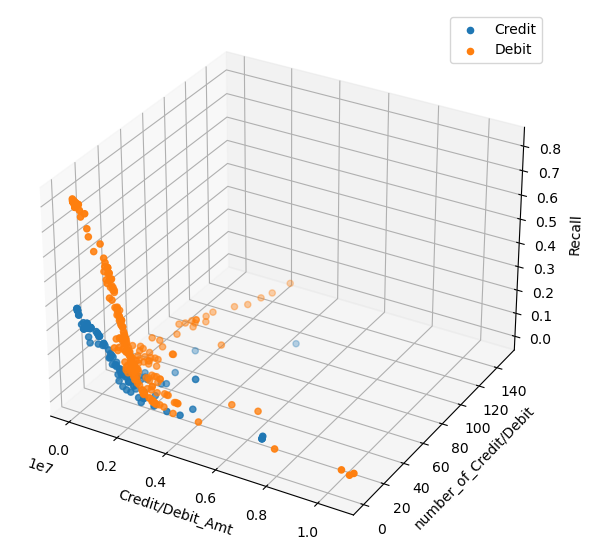

In [56]:
ax = plt.figure(figsize=(7, 7))
ax = plt.subplot(projection = '3d')
ax.scatter3D(credit_distance_results['Credit_Amt'], credit_distance_results['number_of_Credit'], credit_distance_results['recall'], label= 'Credit')
ax.scatter3D(debit_distance_results['Debit_Amt'], debit_distance_results['number_of_Debit'], debit_distance_results['recall'], label= 'Debit')
ax.set_xlabel('Credit/Debit_Amt')
ax.set_ylabel('number_of_Credit/Debit')
ax.set_zlabel('Recall')
plt.legend()
plt.show()

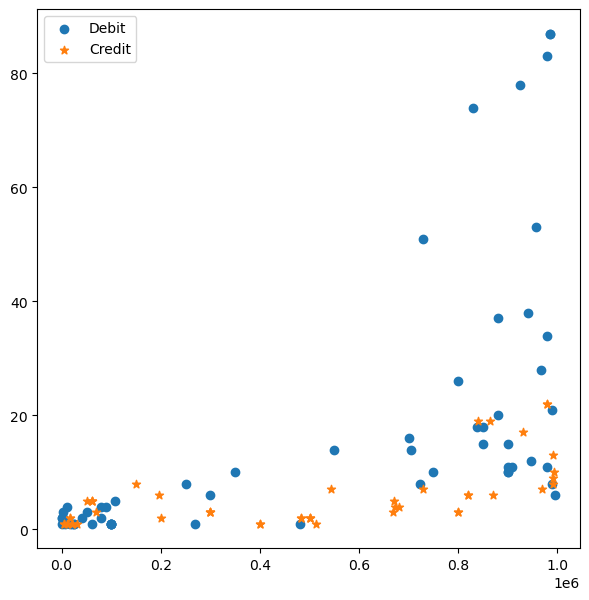

In [66]:
plt.figure(figsize= (7, 7))
szie = 1000000
plt.scatter(debit_distance_results.loc[debit_distance_results['Debit_Amt']<szie, 'Debit_Amt'], debit_distance_results.loc[debit_distance_results['Debit_Amt']<szie, 'number_of_Debit'], label= 'Debit')
plt.scatter(credit_distance_results.loc[credit_distance_results['Credit_Amt']<szie, 'Credit_Amt'], credit_distance_results.loc[credit_distance_results['Credit_Amt']<szie, 'number_of_Credit'], label= 'Credit', marker= '*')
plt.legend()
plt.show()

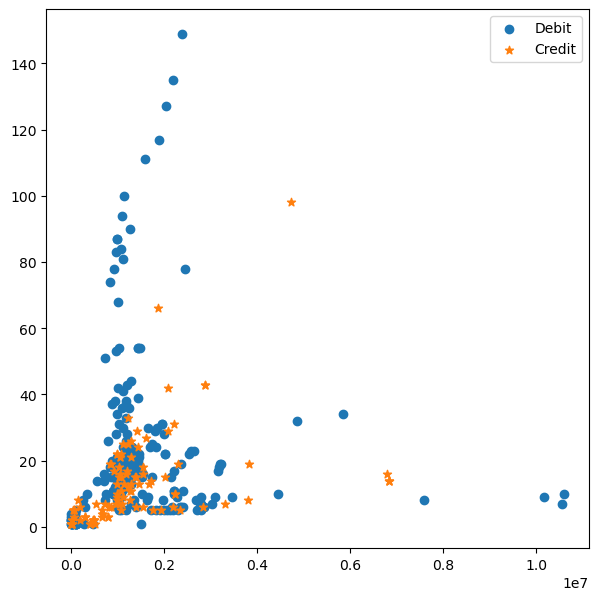

In [57]:
plt.figure(figsize= (7, 7))
plt.scatter(debit_distance_results['Debit_Amt'], debit_distance_results['number_of_Debit'], label= 'Debit')
plt.scatter(credit_distance_results['Credit_Amt'], credit_distance_results['number_of_Credit'], label= 'Credit', marker= '*')
plt.legend()
plt.show()

## binary cross function
只計算 new_sam_1 那邊的

In [24]:
min_infty = float('-inf')

0.6931471805599453

In [30]:
epsilon = np.finfo(np.float32).min
log(epsilon)

ValueError: math domain error

In [36]:
np.log(epsilon)

C:\Users\NCTUUser2\AppData\Local\Temp\4\ipykernel_8960\2846713111.py:1: RuntimeWarning: invalid value encountered in log
  np.log(epsilon)


nan

In [37]:
def BCELOSS(y):
    epilson = 1e-10
    y = y + epilson
    return np.sum(y * np.log(y) + (1 - y * np.log(1 - y))) * (1/len(y))

In [67]:
zero = np.zeros([4,1])
zero

array([[0.],
       [0.],
       [0.],
       [0.]])

In [68]:
z = []
for i in range(4):
    z.append(zero)

b = np.array([[1], [2], [3], [4]])
b

array([[1],
       [2],
       [3],
       [4]])

In [72]:
type(z[0])

numpy.ndarray

In [73]:
z[0].shape

(4, 1)

In [79]:
z = []
for i in range(4):
    z.append(np.zeros((4,1)))

for i in range(4):
    for j in range(4):
        if i == j:
            z[i][j] = b[i]
z

[array([[1.],
        [0.],
        [0.],
        [0.]]),
 array([[0.],
        [2.],
        [0.],
        [0.]]),
 array([[0.],
        [0.],
        [3.],
        [0.]]),
 array([[0.],
        [0.],
        [0.],
        [4.]])]

# four dimension gradient


In [28]:
feature_name = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
K = len(feature_name)

In [29]:
kdtree = cKDTree(train_set[feature_name], leafsize= 100)
tmp = (SAR.loc[:, 'Credit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Credit'].to_numpy()**2 \
    + SAR.loc[:, 'Debit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Debit'].to_numpy()**2) ** (1/2)

SAR.insert(0, 'distance', tmp)
del tmp

In [30]:
idx_distance = SAR.loc[SAR['distance'] != 0].sort_values(by= 'distance').index

In [36]:
distance_results = pd.DataFrame(columns= [feature_name[0], feature_name[1], feature_name[2], feature_name[3], 'recall', 'filterRate', 'distance'])

for i, idx in enumerate(idx_distance):
    point = SAR.loc[idx, feature_name]
    distance = np.sum(point**2) ** (1/2)
    recall_tmp, filterRate_tmp = RecallFilterRate(point, feature_name, train_set)  
    tmp = pd.DataFrame({feature_name[0]: point[0], feature_name[1]: point[1], feature_name[2]: point[2], feature_name[3]: point[3], 'recall': recall_tmp, 'filterRate': filterRate_tmp, 'distance': distance}, index= [i])
    distance_results = pd.concat([distance_results, tmp])

In [37]:
distance_results.sort_values(by= ['distance', 'recall'], ascending= True)

,Credit_Amt,number_of_Credit,Debit_Amt,number_of_Debit,recall,filterRate,distance
0,0.0,0.0,2462.0,2.0,0.812734,0.362063,2.462001e+03
1,200920.0,2.0,0.0,0.0,0.340824,0.445294,2.009200e+05
2,0.0,0.0,270000.0,1.0,0.790262,0.428333,2.700000e+05
3,0.0,0.0,300000.0,6.0,0.730337,0.529677,3.000000e+05
4,0.0,0.0,549945.0,14.0,0.516854,0.756473,5.499450e+05
...,...,...,...,...,...,...,...
262,6840000.0,14.0,0.0,0.0,0.011236,0.994602,6.840000e+06
263,0.0,0.0,7590025.0,8.0,0.011236,0.994103,7.590025e+06
264,0.0,0.0,10160040.0,9.0,0.007491,0.998617,1.016004e+07
265,0.0,0.0,10550015.0,7.0,0.007491,0.998483,1.055002e+07


In [39]:
point0 = distance_results.sort_values(by= 'recall', ascending= False).iloc[0, 0:K]
point0 = point0.to_numpy().reshape(K,1)

In [40]:
#hyperparameter
SAR_type = 'TO_SAR'
step_size = 1
N_max = 1000
father_entropy = Entropy(train_set, SAR_type)

In [1]:
# loss finction
def loss_fn(point, IG, recall):
    lowerbound = np.sum(np.log(point))
    upperbound = 0
    for x, Mx in zip(point, Max_X):
        upperbound += np.log(MX- x)
    #loss = IG + lowerbound + upperbound
    loss = IG + lowerbound + upperbound
    loss = IG + lowerbound + upperbound + recall
    loss = IG * sigmoid(recall) + lowerbound + upperbound
    return loss

In [49]:
def GradIGUpdate(point, feature_name, data):
    n = 0
    results = pd.DataFrame(columns= ['iteration number', feature_name[0], feature_name[1], feature_name[2], feature_name[3], \
                    'new_'+feature_name[0], 'new_'+feature_name[1], 'new_'+feature_name[2], 'new_'+feature_name[3], \
                        'recall', 'filter rate', 'loss'])

    information_gain = -informationGain(point, feature_name, data)
    recall, filter_rate = RecallFilterRate(point, feature_name, data)
    # loss = -informtion_gain 
    loss = loss_fn(point, -information_gain, recall)

    tmp_results = pd.DataFrame({'iteration number':n, feature_name[0]: float(point[0]), feature_name[1]: float(point[1]), feature_name[2]: float(point[2]), feature_name[3]: float(point[3]) \
                    , 'new_'+feature_name[0]: float(point[0]), 'new_'+feature_name[1]: float(point[1]), 'new_'+feature_name[2]: float(point[2]), 'new_'+feature_name[3]: float(point[3]) \
                    ,'information gain': -information_gain, 'recall': recall, 'filter rate': filter_rate, 'loss': loss}, index= [n])
    results = pd.concat([results, tmp_results])
    n += 1

    while True:
        if n > N_max:
            break
        
        gradIG = gradientIG(point, feature_name, data)
        #gradIG = gradIG / np.linalg.norm(gradIG)
        print('gradIG:\n', gradIG)
        if np.all(gradIG == 0):
            print('gradIG has zero')
        new_point = point - step_size * gradIG

        information_gain = -informationGain(new_point, feature_name, data)
        recall, filter_rate = RecallFilterRate(new_point, feature_name, data)
        # loss = -information_gain 
        loss = loss_fn(point, information_gain, recall)

        print(f'n={n}, {feature_name[0]}:{float(new_point[0])}, {feature_name[1]}: {float(new_point[1])}' \
            ,f'{feature_name[2]}: {float(new_point[2])}, {feature_name[3]}: {float(new_point[3])}' \
            , f'\ninformation gain: {information_gain}, recall:{recall}, filter rate:{filter_rate}, loss: {loss}')
        
        tmp_results = pd.DataFrame({'iteration number':n, feature_name[0]: float(point[0]), feature_name[1]: float(point[1]), feature_name[2]: float(point[2]), feature_name[3]: float(point[3]) \
                        , 'new_'+feature_name[0]: float(new_point[0]), 'new_'+feature_name[1]: float(new_point[1]), 'new_'+feature_name[2]: float(new_point[2]), 'new_'+feature_name[3]: float(new_point[3]) \
                        ,'information gain': information_gain, 'recall': recall, 'filter rate': filter_rate, 'loss': loss}, index= [n])

        results = pd.concat([results, tmp_results])
        n += 1
        point = new_point

    return results


In [50]:
# loss funciton only information gain 
if __name__ == '__main__':
    np.random.seed(1111)
    print('initial point\n', point0)
    results = GradIGUpdate(point0, feature_name, train_set)

initial point
 [[0.000e+00]
 [0.000e+00]
 [2.462e+03]
 [2.000e+00]]
gradIG:
 [[ 2.64009268e-09]
 [ 1.47400868e-05]
 [-1.66750899e-09]
 [ 1.62843352e-05]]
n=1, Credit_Amt:-2.6400926807312637e-09, number_of_Credit: -1.4740086815880071e-05 Debit_Amt: 2462.0000000016676, number_of_Debit: 1.9999837156647664 
information gain: -0.0005206285701108079, recall:0.8089887640449438, filter rate:0.36208221283134845, loss: 0.0005206285701108079
gradIG:
 [[ 1.77304169e+05]
 [ 3.17568984e+01]
 [-0.00000000e+00]
 [-8.88910794e+00]]
n=2, Credit_Amt:-177304.16912725903, number_of_Credit: -31.756913123596053 Debit_Amt: 2462.0000000016676, number_of_Debit: 10.889091660008566 
information gain: -0.001157718359694207, recall:0.5842696629213483, filter rate:0.6867844794467922, loss: 0.001157718359694207
gradIG:
 [[ 5.86594471e-09]
 [ 3.27505526e-05]
 [-0.00000000e+00]
 [-5.53866013e-05]]
n=3, Credit_Amt:-177304.1691272649, number_of_Credit: -31.756945874148634 Debit_Amt: 2462.0000000016676, number_of_Debit: 1

In [51]:
results.loc[[0, 1000]]

,iteration number,Credit_Amt,number_of_Credit,Debit_Amt,number_of_Debit,new_Credit_Amt,new_number_of_Credit,new_Debit_Amt,new_number_of_Debit,recall,filter rate,loss,information gain
0,0,0.000000,0.000000,2462.0,2.000000,0.000000,0.000000,2462.0,2.000000,0.812734,0.362063,-0.000017,-0.000017
1000,1000,-177304.169133,-31.789549,2462.0,10.944142,-177304.169133,-31.789581,2462.0,10.944197,0.584270,0.686784,0.001158,0.001158


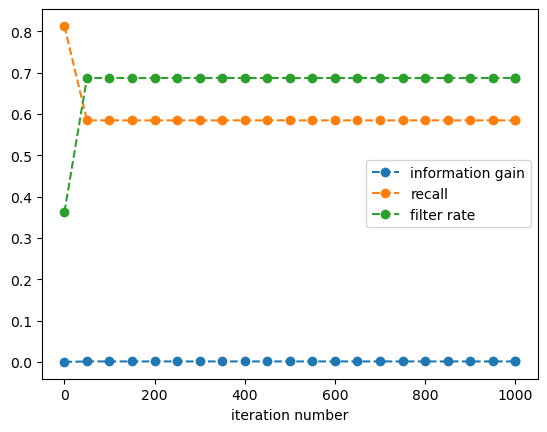

In [52]:
plot_results(results)

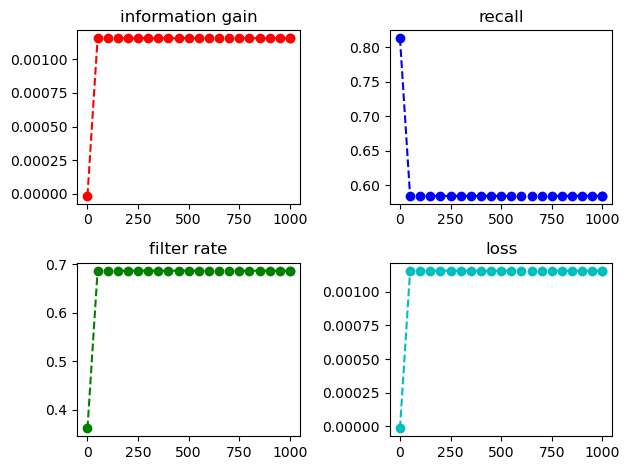

In [53]:
plot_seperator(results)

### Add back the boundary of the data with penalty function

In [ ]:
# loss funciton with information gain and the boundary condition
if __name__ == '__main__':
    np.random.seed(1111)
    print('initial point\n', point0)
    results = GradIGUpdate(point0, feature_name, train_set)

In [ ]:
results.loc[[0, 1000]]

In [ ]:
plot_results(results)

In [ ]:
plot_seperator(results)